Your name: Darshan Rajesh Tina

Your Andrew ID:dtina


# Part 1: Email spam classification 

### (a) Print the number of ham and spam emails 

In [1]:
#your code here
import glob
ham_files = glob.glob('ham/*.beck.ham.txt')
spam_files = glob.glob('spam/*.spam.txt')

In [2]:
print('Length of spam emails is',len(spam_files))
print('Length of ham emails is ',len(ham_files))

Length of spam emails is 3671
Length of ham emails is  1500


#### We can see that the number of ham emails are less than half of the spam emails recieved and can say that the dataset is imbalanced. This would create a problem in training a classifier, as classifiers tend to be baised towards groups that hold a large proportion of the dataset. To avoid this we could perform oversampling of the group with less amount of data and avoid the imbalance in the dataset

### (b) Construct the documents 
 

In [3]:
import re
import string
import codecs

def makeWordList(path):
    
    with codecs.open(path, "r", encoding='utf-8', errors='ignore') as f:
        corpus_text = f.read()

    for c in string.punctuation:
        corpus_text = corpus_text.replace(c, "")  # -- (1)
    
    text = re.sub(r'\S*\d\S*','',corpus_text) # -- (2)
    text = re.sub(r'[^\w\s]','',text)         # -- (3)
    
    text = text.lower().split()           # -- (4)         
    
    li = []
    for token in text:
        li.append(token)

    return " ".join(li)

In [4]:
#your code here
testing = []
ham_spam_indices = []
for i in spam_files:
    testing.append(makeWordList(i))
    ham_spam_indices.append(1)
for i in ham_files:
    testing.append(makeWordList(i))
    ham_spam_indices.append(0)

In [5]:
#len(ham_spam_indices)

### (c) Construct the document matrix `X` as a matrix of word frequencies 

   - Using the `CountVectorizer` from scikit-learn.
   - Setting `min_df=50`; this drops words that don't occur in at least 50 documents.
   - Setting `stop_words="english"` and `max_df=0.8` to filter out stop-words.
   - Printing the size of the vocabulary (number of unique words)

In [6]:
#your code here
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(stop_words='english',min_df=50,max_df=0.5)
X = cv.fit_transform(testing)

In [7]:
print('The size of the vocabulary is',len(cv.vocabulary_))

The size of the vocabulary is 1680


### (d) k-NN, SVM, random forest: Hyperparameter selection 

Now that we have our documents and labels as training data, we can perform 5-fold cross-validation to select the hyperparameters for different learning algorithms.

The hyperparameter with the best performance averaged across 5 folds is chosen. Using the **weighted F1-score** as the evaluation metric 



### KNN

In [8]:
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
from sklearn.metrics import f1_score

In [9]:
X

<5171x1680 sparse matrix of type '<class 'numpy.int64'>'
	with 246712 stored elements in Compressed Sparse Row format>

In [10]:
train_data = X.toarray()

In [11]:
y_value = np.array(ham_spam_indices)

In [12]:
train_data.shape

(5171, 1680)

In [13]:
from sklearn import svm
from sklearn.model_selection import KFold

num_folds = 5
k_fold = KFold(num_folds)
indices = range(1,len(ham_spam_indices)+1)
hyperparameter_settings = [i for i in range(2,11)]  # fill this with hyperparameter settings that you want to try 
best_hyperparam_setting = None
best_cross_val_score = -np.inf  # assumes that a higher score is better
for hyperparam_setting in hyperparameter_settings:
    fold_scores = []
    classifier = KNeighborsClassifier(n_neighbors=hyperparam_setting)    
    for train,test in k_fold.split(indices):
        classifier.fit(X[train],np.array(ham_spam_indices)[train])
        predicted_labels = classifier.predict(X[train])
        score = f1_score(predicted_labels,np.array(ham_spam_indices)[train],average='weighted')
        fold_scores.append(score)
        #print(fold_scores)
    # your code to train and score the training data here
    cross_val_score = np.mean(fold_scores)
    #print(cross_val_score)
    if cross_val_score > best_cross_val_score:  # assumes that a higher score is better
        best_cross_val_score = cross_val_score
        best_hyperparam_setting = hyperparam_setting

print('Best hyperparameter setting:', best_hyperparam_setting)

Best hyperparameter setting: 2


In [14]:
print(best_cross_val_score)

0.9918982139459711


### SVM

In [15]:
#SVM
%time
C_range = np.logspace(-8, 0, 8)
best_c = None
best_cross_val_score_svm = -np.inf  # assumes that a higher score is better
for c in C_range:
    fold_svm_scores = []
    clf = svm.SVC(kernel='rbf',C=c)
    for train,test in k_fold.split(indices):
        clf.fit(X[train],np.array(ham_spam_indices)[train])
        ypred = clf.predict(X[train])
        score = f1_score(ypred,np.array(ham_spam_indices)[train],average='weighted')
        fold_svm_scores.append(score)
    
    cross_val_score_svm = np.mean(fold_svm_scores)
    
    if cross_val_score_svm>best_cross_val_score_svm:
        best_cross_val_score_svm=cross_val_score_svm
        best_c = c
print('Best c value is',best_c)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.96 µs


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Best c value is 1.0


In [16]:
best_cross_val_score

0.9918982139459711

### Random Forest

In [17]:
#Random forest 
from sklearn.ensemble import RandomForestClassifier

In [18]:
best_hyperparameter_setting = None
score_best_rf = -np.inf
hyperparameter_settings = [(num_trees, max_depth)
                           for num_trees in [50, 100, 150, 200]
                           for max_depth in [3, 4, 5, None]]
for hyperparameter_setting in hyperparameter_settings:
    num_trees, max_depth = hyperparameter_setting
    fold_score = []
    for train_indices, val_indices in k_fold.split(indices):
        classifier = RandomForestClassifier(n_estimators=num_trees,max_depth=max_depth,random_state=0)
        classifier.fit(X[train_indices],y_value[train_indices])
        y_pred = classifier.predict(X[train_indices])
        #y_val = classifier.predict(X[val_indices])
        score = f1_score(y_value[train_indices],y_pred)
        fold_score.append(score)
    cross_val_rf_score = np.mean(fold_score)
    
    if cross_val_rf_score>score_best_rf:
        score_best_rf = cross_val_rf_score
        best_n_estimators = num_trees
        best_max_depth = max_depth
print('Best n estimators is',best_n_estimators)
print('Best max depth is',max_depth)

Best n estimators is 50
Best max depth is None


In [19]:
score_best_rf

0.9998540198582854

### (e) Classifier testing: Precision-Recall and ROC curves [20 points]

   - Using the best hyperparameters for each classifier from the previous question to **train** your classifiers on the training data.
   - Using test emails to in the `testing` folder to **test** your classifiers and construct the plots below.



In [20]:
#your code here
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X,y_value)
test_data = glob.glob('testing/*.txt')
test_data_content = []
test_indices=[]
for i in test_data:
    if 'ham' in i:
        test_indices.append(0)
    else:
        test_indices.append(1)
    test_data_content.append(makeWordList(i))

In [21]:
T = cv.transform(test_data_content)
test_pred = knn.predict(T)
predicted_prob_values_test_knn = knn.predict_proba(T)
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(test_indices, predicted_prob_values_test_knn[:,1])

In [22]:
import matplotlib.pyplot as plt

In [23]:
svm_cf = svm.SVC(kernel='rbf',C=1,probability=True)
svm_cf.fit(X,y_value)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [24]:
svm_test_prob = svm_cf.predict_proba(T)
fpr1, tpr1, thresholds1 = roc_curve(test_indices, svm_test_prob[:,1],pos_label=1)

In [25]:
random_forest_test = RandomForestClassifier(n_estimators=50,max_depth=None,random_state=0)
random_forest_test.fit(X,y_value)
random_y_predict_prob = random_forest_test.predict_proba(T)

In [26]:
fpr2,tpr2,threshold2 = roc_curve(test_indices, random_y_predict_prob[:,1],pos_label=1)

In [27]:
auc = np.trapz(fpr,tpr)
auc_1 = np.trapz(fpr1,tpr1)
auc_2 = np.trapz(fpr2,tpr2)

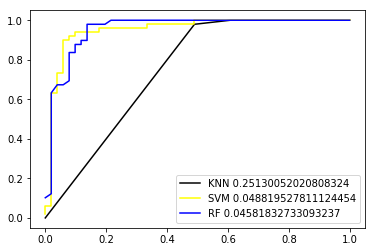

In [30]:
#ROC curve
plt.plot(fpr,tpr,color='black',label='KNN '+str(auc))
plt.plot(fpr1, tpr1,color='yellow',label='SVM '+str(auc_1))
plt.plot(fpr2,tpr2,color='blue',label='RF '+str(auc_2))
plt.legend()
plt.show()

In [31]:
knn_test_pred = knn.predict(T)
svm_test_pred = svm_cf.predict(T)
random_test_pred = random_forest_test.predict(T)

In [32]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [33]:
from sklearn.metrics import precision_recall_curve

In [34]:
precision_knn,recall_knn,threshold_knn = precision_recall_curve(test_indices,predicted_prob_values_test_knn[:,1])
precision_svm, recall_svm, threshold_svm = precision_recall_curve(test_indices,svm_test_prob[:,1])
precision_rf, recall_rf, threshold_rf = precision_recall_curve(test_indices,random_y_predict_prob[:,1])
# plt.plot(prec_score,rec)
# plt.show()
knn_precision_score = np.mean(precision_knn)
svm_precision_score = np.mean(precision_svm)
rf_precision_score = np.mean(precision_rf)

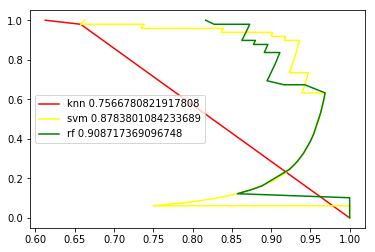

In [35]:
# Precision-recall curve
plt.plot(precision_knn,recall_knn,color='red',label='knn '+str(knn_precision_score))
plt.plot(precision_svm, recall_svm,color='yellow',label='svm '+str(svm_precision_score))
plt.plot(precision_rf, recall_rf,color='green',label='rf '+str(rf_precision_score))
plt.legend()
plt.show()

#### We would prefer precision-recall curve over ROC as the data that we are dealing with is a imbalanced dataset. Since it is a imbalanced dataset precision and recall will help us understand the number of correctly predicted label and are the true labels correctly identified from the dataset

#### According to ROC, Random forest classifier gives us the best results

# Part 2: Image Segmentation 

### Set up the environment

In [3]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt

import coco
import utils
import model as modellib
from model import log
import visualize
from config import Config
from shapes import ShapesDataset

from pycocotools.coco import COCO

%matplotlib inline 

ROOT_DIR = os.getcwd()
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

/home/ubuntu/anaconda3/lib/python3.6/site-packages/pycocotools/coco.py:49: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/ubuntu/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/ubuntu/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/ubuntu/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
  

### Model configuration

These lines specify how many GPUs to use, and how many images to process in parallel on each GPU.

In [4]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
#config.display()

### Load the pre-trained model

This is actually a Keras model wrapped along with some helpful functions. The model may be loaded in two modes: `training` and `inference` (testing) mode. `model_dir` points towards a directory to save logs and trained weights, which we have set above as the `/logs` directory.

In [5]:
%%time
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)
model.load_weights(COCO_MODEL_PATH, by_name=True)

CPU times: user 8.95 s, sys: 588 ms, total: 9.54 s
Wall time: 11.3 s


### Hard-code object classes

For the small dataset of images we are using, we define our own list of class names and class indices for each object. These are of various types: for example, "car", "bicycle", etc..

In [6]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

### Load and visualize a random image



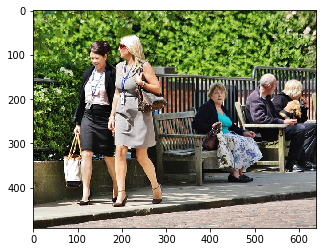

In [7]:
file_names = next(os.walk(IMAGE_DIR))[2]
image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))
plt.imshow(image)
plt.show()

### Test the pre-trained model

We now call the `detect` function of the model on the list of images we want to be segmented. This returns a `result` object; inspect this object to see what it contains.

The `visualize` helper module provides useful functions to visualize our segmentation results. Understand how this function works (SHIFT+TAB in Jupyter is useful, as well as looking at the code in `visualize.py` directly).

Processing 1 images
image                    shape: (491, 640, 3)         min:    0.00000  max:  255.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000
image_metas              shape: (1, 89)               min:    0.00000  max: 1024.00000
CPU times: user 7.82 s, sys: 3.09 s, total: 10.9 s
Wall time: 13 s


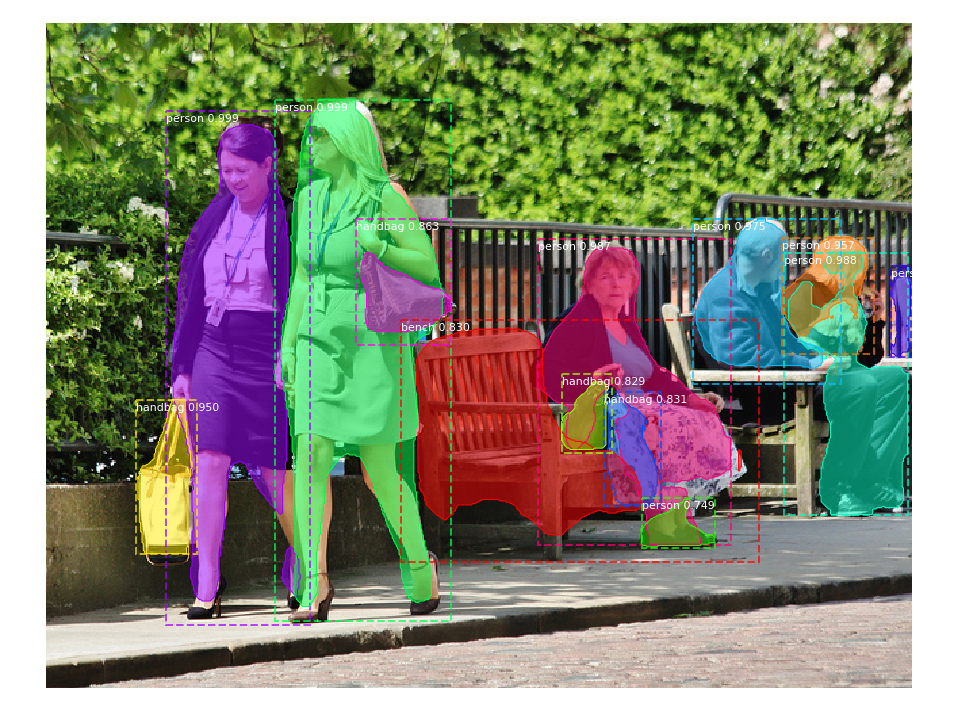

In [8]:
%%time
results = model.detect([image], verbose=1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

### Training from scratch

Now that we understand what a properly trained model should do, we consider training a model from scratch.

### Load the data

Load the annotations for the training images into memory.

In [9]:
%%time
config = coco.CocoConfig()
COCO_DIR = "2014"
dataset = coco.CocoDataset()
dataset.load_coco(COCO_DIR, "minival")
dataset.prepare()

loading annotations into memory...
Done (t=0.69s)
creating index...
index created!
CPU times: user 672 ms, sys: 44 ms, total: 716 ms
Wall time: 819 ms


Now load the same for the test images.

In [10]:
%%time
dataset_val = coco.CocoDataset()
dataset_val.load_coco(COCO_DIR, "val35k")
dataset_val.prepare()

loading annotations into memory...
Done (t=5.29s)
creating index...
index created!
CPU times: user 5.09 s, sys: 352 ms, total: 5.44 s
Wall time: 6.17 s


### List a few object classes

In [11]:
print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))
    if i > 10:
        break

Image Count: 4952
Class Count: 81
  0. BG                                                
  1. person                                            
  2. bicycle                                           
  3. car                                               
  4. motorcycle                                        
  5. airplane                                          
  6. bus                                               
  7. train                                             
  8. truck                                             
  9. boat                                              
 10. traffic light                                     
 11. fire hydrant                                      


### Visualize a random image and its annotations

image_id  3486 http://cocodataset.org/#explore?id=480936
image                    shape: (640, 482, 3)         min:    0.00000  max:  255.00000
mask                     shape: (640, 482, 5)         min:    0.00000  max:    1.00000
class_ids                shape: (5,)                  min:    1.00000  max:   74.00000
bbox                     shape: (5, 4)                min:    0.00000  max:  640.00000


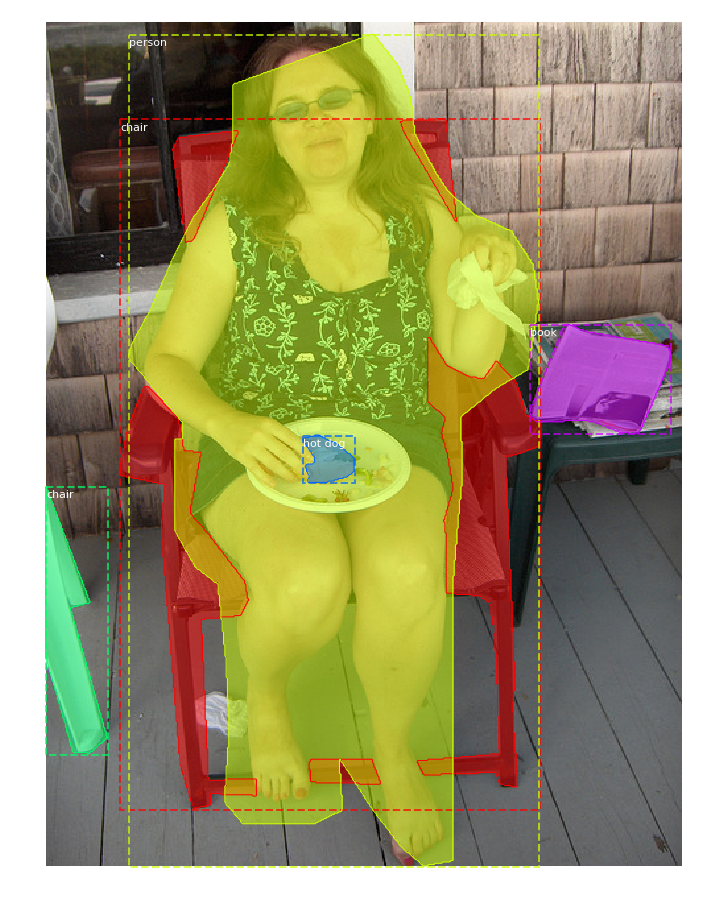

In [12]:
# Load random image and mask.
image_id = random.choice(dataset.image_ids)
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id, dataset.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)

# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

### Training configuration

See the default configuration values in `config.py`.

In [13]:
class TrainConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    STEPS_PER_EPOCH = 60

config = TrainConfig()
config.display()


Configurations:
BACKBONE_SHAPES                [[256 256]
 [128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_MIN_DIM                  800
IMAGE_PADDING                  True
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.002
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           coco
NUM_CLASSES                    81
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_NMS_ROIS_TRAINING     

### (b) Create a new model in training mode 

In [19]:
new_model = modellib.MaskRCNN(mode='training',model_dir=MODEL_DIR, config=config)
new_model.load_weights(COCO_MODEL_PATH, by_name=True,exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
          "mrcnn_bbox", "mrcnn_mask"])

### (c) Train the model for 10 epochs 


In [20]:
%%time
# call to train
new_model.train(dataset,dataset_val,layers="heads",learning_rate=config.LEARNING_RATE,epochs=10)


Starting at epoch 0. LR=0.002

Checkpoint Path: /home/ubuntu/HW3/files/logs/coco20190226T2150/mask_rcnn_coco_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn

/home/ubuntu/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/ubuntu/anaconda3/lib/python3.6/site-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/10


/home/ubuntu/anaconda3/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:583: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:583: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


60/60 [==============================] - 72s 1s/step - loss: 3.4587 - rpn_class_loss: 0.0224 - rpn_bbox_loss: 0.4245 - mrcnn_class_loss: 1.5396 - mrcnn_bbox_loss: 0.8563 - mrcnn_mask_loss: 0.6159 - val_loss: 3.3929 - val_rpn_class_loss: 0.1018 - val_rpn_bbox_loss: 0.7240 - val_mrcnn_class_loss: 1.4382 - val_mrcnn_bbox_loss: 0.5894 - val_mrcnn_mask_loss: 0.5396
Epoch 2/10
60/60 [==============================] - 55s 922ms/step - loss: 2.4111 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 0.3780 - mrcnn_class_loss: 0.9121 - mrcnn_bbox_loss: 0.6131 - mrcnn_mask_loss: 0.4863 - val_loss: 3.5504 - val_rpn_class_loss: 0.1247 - val_rpn_bbox_loss: 0.7258 - val_mrcnn_class_loss: 1.5857 - val_mrcnn_bbox_loss: 0.5312 - val_mrcnn_mask_loss: 0.5830
Epoch 3/10
60/60 [==============================] - 56s 928ms/step - loss: 2.1688 - rpn_class_loss: 0.0212 - rpn_bbox_loss: 0.3095 - mrcnn_class_loss: 0.8125 - mrcnn_bbox_loss: 0.5314 - mrcnn_mask_loss: 0.4941 - val_loss: 2.6051 - val_rpn_class_loss: 0.1221 - 

### (d) Visualize learning progress with TensorBoard 


 <img src="yourloss.PNG"/>

### (e) Test model 

Load the model in inference (testing) mode.

In [21]:
# load model
model = modellib.MaskRCNN(mode='inference',model_dir=MODEL_DIR, config=config)

Load the last trained model weights.

In [22]:
model_path = model.find_last()[1] # use the last trained weights
model.load_weights(model_path, by_name=True)

Visualize the true annotations of a random test image.

original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000
image_meta               shape: (89,)                 min:    1.00000  max: 1323.00000
gt_class_id              shape: (3, 4)                min:  218.00000  max:  883.00000
gt_bbox                  shape: (3, 4)                min:  218.00000  max:  883.00000
gt_mask                  shape: (1024, 1024, 3)       min:    0.00000  max:    1.00000


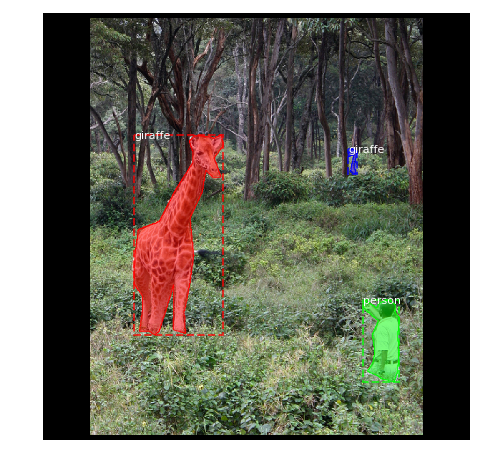

In [32]:
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_bbox)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset.class_names, figsize=(8, 8))

Visualize the predicted annotations for this image

image_id  1323 http://cocodataset.org/#explore?id=518213
image                    shape: (640, 512, 3)         min:    0.00000  max:  255.00000
mask                     shape: (640, 512, 3)         min:    0.00000  max:    1.00000
class_ids                shape: (3,)                  min:    1.00000  max:   24.00000
bbox                     shape: (3, 4)                min:   68.00000  max:  557.00000


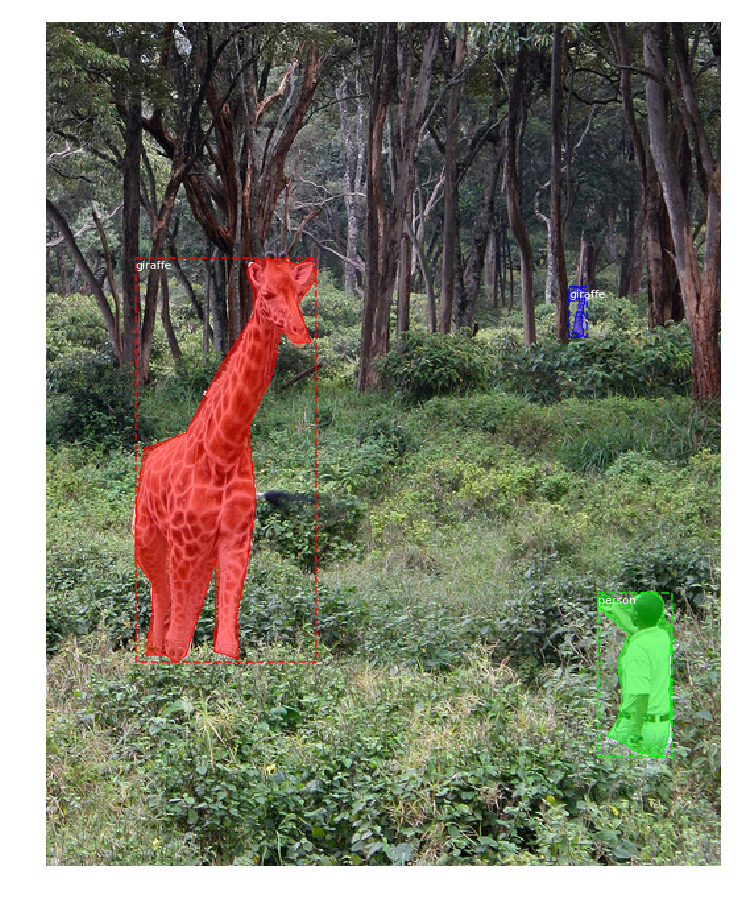

In [33]:
##image_id = random.choice(dataset_val.image_ids)
image = dataset_val.load_image(image_id)
mask, class_ids = dataset_val.load_mask(image_id)
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id, dataset.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)

# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

# Part 3: Sentiment Analysis 



### (a) Read the training data  


In [1]:
import pandas as pd

In [2]:
names = ['Sentiment','id','Timeframe','query','Name','Text']

In [4]:
train_data = pd.read_csv('HW3-data/train.csv',encoding='iso8859',names=names)
#test_data = pd.read_csv('HW3-data/test.csv',encoding='iso8859',names=names)

In [5]:
train_data.drop(labels=['id','Timeframe','query','Name'],axis=1,inplace=True)

In [6]:
import numpy as np

In [8]:
train_data = train_data.reindex(np.random.permutation(train_data.index))

In [9]:
#Print first 5 sentiments
train_data.head(5)

Sentiment                                               Text
853411           1  ooo yeaaa I am  hahah wtf r they actually real...
1089101          1                                @jimyvr yes and no 
1085475          1  @Infantry11bdub So he should back off and grow...
63109            0  what DOES one do with a &quot;worhaholic&quot;...
184519           0  watched hostel 2 and fell into a nightmare sleep

In [10]:
print('Number of Negative sentiments are',len(train_data[train_data['Sentiment']==0]))
print('Number of Positive sentiments are',len(train_data[train_data['Sentiment']==1]))

Number of Negative sentiments are 800000
Number of Positive sentiments are 800000


### (b) Data Preparation 

In [11]:
# your code here
sentiment_text = train_data.head(5000)['Text']

In [12]:
sentiment_text_list = list(sentiment_text.values)

In [13]:
#Here above sentiment_text_list contains list of strings

2\. Use `Tokenizer` from `keras.preprocessing.text` to tokenize the texts and convert them to sequences (numbers) with the `texts_to_sequences` method of `Tokenizer`. **When tokenizing, please only consider the top 10,000 words in the dataset (`num_words`=10,000)**. [4 pts]

In [14]:
# your code here
li = []
from keras.preprocessing.text import Tokenizer
tok = Tokenizer(num_words=10000)
tok.fit_on_texts(sentiment_text_list)
word_number_sequence = tok.texts_to_sequences(sentiment_text_list)

Using TensorFlow backend.


3\. Use `pad_sequences` from `keras.preprocessing.sequence` to pad each sequence with zeros to **make the sequence length 120**. [2 pts]

In [15]:
# your code here
from keras.preprocessing.sequence import pad_sequences
word_padded = pad_sequences(word_number_sequence,maxlen=120)

In [16]:
word_padded.shape

(5000, 120)

###  (c) Simple RNN 

In [17]:
from keras.layers import SimpleRNN, Embedding# your code here
from keras.models import Sequential
from keras.layers import Dense

In [18]:
simple_rnn = Sequential()
simple_rnn.add(Embedding(input_dim=10000,output_dim=64))
simple_rnn.add(SimpleRNN(2))
simple_rnn.add(Dense(1,activation='sigmoid'))

ii) Now train the simple RNN model:

1\. Compile the model with binary cross entory as loss and accuracy as evaluation metrics.

In [19]:
# your code here
simple_rnn.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['acc'])


2\. Fit the model with the training set with 5 epochs (use 20% of the data as validation). 

In [22]:
# your code here
hist = simple_rnn.fit(word_padded,train_data.head(5000)['Sentiment'],epochs=5,validation_split=0.2,batch_size=1024)

Train on 4000 samples, validate on 1000 samples
Epoch 1/5
4000/4000 [==============================] - 5s 1ms/step - loss: 0.6940 - acc: 0.5075 - val_loss: 0.6863 - val_acc: 0.5420
Epoch 2/5
4000/4000 [==============================] - 0s 70us/step - loss: 0.6256 - acc: 0.7467 - val_loss: 0.6847 - val_acc: 0.5450
Epoch 3/5
4000/4000 [==============================] - 0s 66us/step - loss: 0.5780 - acc: 0.8647 - val_loss: 0.6776 - val_acc: 0.5720
Epoch 4/5
4000/4000 [==============================] - 0s 60us/step - loss: 0.5434 - acc: 0.9110 - val_loss: 0.6794 - val_acc: 0.5610
Epoch 5/5
4000/4000 [==============================] - 0s 58us/step - loss: 0.5139 - acc: 0.9328 - val_loss: 0.6754 - val_acc: 0.5820


3\. Plot the training and validation accuracy across epochs.

In [24]:
import matplotlib.pyplot as plt

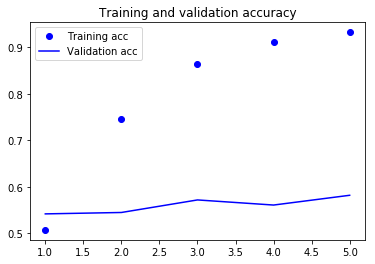

In [25]:
# your code here
acc = hist.history['acc']
val_acc = hist.history['val_acc']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

### (d) LSTM 

i)  Now built a LSTM model by replacing the simple RNN layter in the above model with a LSTM layer. Print a summary of the LSTM model.

In [27]:
# your code here
from keras.layers import LSTM
lstm = Sequential()
lstm.add(Embedding(input_dim=10000,output_dim=64))
lstm.add(LSTM(2))
lstm.add(Dense(1,activation='sigmoid'))
lstm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 64)          640000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 2)                 536       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 3         
Total params: 640,539
Trainable params: 640,539
Non-trainable params: 0
_________________________________________________________________


ii) Train the LSTM model with the same specifications in the simple RNN model. Again, plot the training and validation accuracy across epochs.

In [29]:
# your code here
lstm.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['acc'])
hist_l = lstm.fit(word_padded,train_data.head(5000)['Sentiment'],epochs=5,validation_split=0.2,batch_size=1024)

Train on 4000 samples, validate on 1000 samples
Epoch 1/5
4000/4000 [==============================] - 2s 447us/step - loss: 0.6918 - acc: 0.5510 - val_loss: 0.6896 - val_acc: 0.6310
Epoch 2/5
4000/4000 [==============================] - 1s 220us/step - loss: 0.6849 - acc: 0.7412 - val_loss: 0.6866 - val_acc: 0.6510
Epoch 3/5
4000/4000 [==============================] - 1s 224us/step - loss: 0.6787 - acc: 0.7858 - val_loss: 0.6837 - val_acc: 0.6600
Epoch 4/5
4000/4000 [==============================] - 1s 220us/step - loss: 0.6725 - acc: 0.7995 - val_loss: 0.6807 - val_acc: 0.6600
Epoch 5/5
4000/4000 [==============================] - 1s 221us/step - loss: 0.6661 - acc: 0.8090 - val_loss: 0.6778 - val_acc: 0.6600


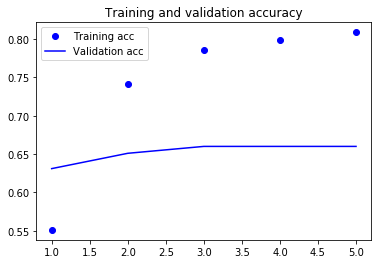

In [30]:
# your code here
acc = hist_l.history['acc']
val_acc = hist_l.history['val_acc']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

### (e) Evaluation on test data [14 points]

In [36]:
# your code here
test_data = pd.read_csv('HW3-data/test.csv',encoding='iso8859',names=names)
test_data.drop(labels=['id','Timeframe','query','Name'],axis=1,inplace=True)
sentiment_test_list = list(test_data['Text'].values)

In [38]:
test_seq = tok.texts_to_sequences(sentiment_test_list)
test_seq_padded = pad_sequences(test_seq,maxlen=120)

In [39]:
simple_test_acc, simple_test_loss = simple_rnn.evaluate(test_seq_padded,test_data['Sentiment'])
print('Simple RNN')
print('Test accuracy is ',simple_test_acc)
lst_test_acc, lst_test_loss = lstm.evaluate(test_seq_padded,test_data['Sentiment'])
print('LSTM')
print('Test accuracy is ',lst_test_acc)

498/498 [==============================] - 0s 309us/step
Simple RNN
Test accuracy is  0.6946690003555941
498/498 [==============================] - 1s 1ms/step
LSTM
Test accuracy is  0.6896009976605335


### For simple RNN, we observe the raw test accuracy to be equal to 0.694669
### For LSTM, we observe the raw test accuracy to be equal to 0.6896

#### Full model

In [40]:
# your code here
full_sentiment = train_data['Text']

In [43]:
full_sentiment_list = list(full_sentiment.values)

In [44]:
# your code here
li = []
from keras.preprocessing.text import Tokenizer
tok = Tokenizer(num_words=10000)
tok.fit_on_texts(full_sentiment_list)
word_number_sequence = tok.texts_to_sequences(full_sentiment_list)

In [45]:
# your code here
from keras.preprocessing.sequence import pad_sequences
word_padded = pad_sequences(word_number_sequence,maxlen=120)

In [46]:
simple_rnn = Sequential()
simple_rnn.add(Embedding(input_dim=10000,output_dim=64))
simple_rnn.add(SimpleRNN(2))
simple_rnn.add(Dense(1,activation='sigmoid'))

In [47]:
# your code here
simple_rnn.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['acc'])
# your code here
hist = simple_rnn.fit(word_padded,train_data['Sentiment'],epochs=5,validation_split=0.2,batch_size=1024)

Train on 1280000 samples, validate on 320000 samples
Epoch 1/5
1280000/1280000 [==============================] - 74s 58us/step - loss: 0.4909 - acc: 0.7760 - val_loss: 0.4546 - val_acc: 0.7950
Epoch 2/5
1280000/1280000 [==============================] - 73s 57us/step - loss: 0.4455 - acc: 0.7993 - val_loss: 0.4438 - val_acc: 0.8001
Epoch 3/5
1280000/1280000 [==============================] - 73s 57us/step - loss: 0.4379 - acc: 0.8028 - val_loss: 0.4416 - val_acc: 0.8015
Epoch 4/5
1280000/1280000 [==============================] - 74s 58us/step - loss: 0.4350 - acc: 0.8038 - val_loss: 0.4394 - val_acc: 0.8018
Epoch 5/5
1280000/1280000 [==============================] - 74s 57us/step - loss: 0.4336 - acc: 0.8048 - val_loss: 0.4393 - val_acc: 0.8018


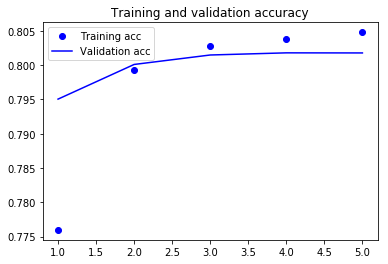

In [48]:
# your code here
acc = hist.history['acc']
val_acc = hist.history['val_acc']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

In [49]:
# your code here
from keras.layers import LSTM
lstm = Sequential()
lstm.add(Embedding(input_dim=10000,output_dim=64))
lstm.add(LSTM(2))
lstm.add(Dense(1,activation='sigmoid'))
lstm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 64)          640000    
_________________________________________________________________
lstm_3 (LSTM)                (None, 2)                 536       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 3         
Total params: 640,539
Trainable params: 640,539
Non-trainable params: 0
_________________________________________________________________


In [50]:
# your code here
lstm.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['acc'])
hist_l = lstm.fit(word_padded,train_data['Sentiment'],epochs=5,validation_split=0.2,batch_size=1024)

Train on 1280000 samples, validate on 320000 samples
Epoch 1/5
1280000/1280000 [==============================] - 279s 218us/step - loss: 0.4827 - acc: 0.7876 - val_loss: 0.4329 - val_acc: 0.8018
Epoch 2/5
1280000/1280000 [==============================] - 280s 218us/step - loss: 0.4218 - acc: 0.8066 - val_loss: 0.4209 - val_acc: 0.8063
Epoch 3/5
1280000/1280000 [==============================] - 279s 218us/step - loss: 0.4123 - acc: 0.8112 - val_loss: 0.4168 - val_acc: 0.8091
Epoch 4/5
1280000/1280000 [==============================] - 278s 217us/step - loss: 0.4068 - acc: 0.8143 - val_loss: 0.4127 - val_acc: 0.8112
Epoch 5/5
1280000/1280000 [==============================] - 278s 217us/step - loss: 0.4030 - acc: 0.8170 - val_loss: 0.4108 - val_acc: 0.8123


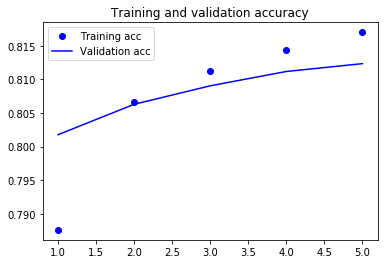

In [51]:
# your code here
acc = hist_l.history['acc']
val_acc = hist_l.history['val_acc']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

In [52]:
test_seq = tok.texts_to_sequences(sentiment_test_list)
test_seq_padded = pad_sequences(test_seq,maxlen=120)

In [53]:
simple_test_acc, simple_test_loss = simple_rnn.evaluate(test_seq_padded,test_data['Sentiment'])
print('Simple RNN')
print('Test accuracy is ',simple_test_acc)
lst_test_acc, lst_test_loss = lstm.evaluate(test_seq_padded,test_data['Sentiment'])
print('LSTM')
print('Test accuracy is ',lst_test_acc)

498/498 [==============================] - 0s 299us/step
Simple RNN
Test accuracy is  0.7098180069980851
498/498 [==============================] - 1s 1ms/step
LSTM
Test accuracy is  0.8422037600034691


### For simple RNN
**We observe the 5 validation accuracies one for each epoch: 0.7950, 0.8001, 0.8015, 0.8018,0.8018
The test accuracy here is equal to 0.7098 which is lower than the validation accuracy**

**Test accuracy for the entire training data is greater than that of the test accuracy achieved for 5000 sample of data
Test accuracy for the entire data set 0.70981 and for the 5000 sample size is equal to 0.69466**

**The differnece in the test accuracies is not that significant for a simple RNN model**

### For LSTM, 
**we observe 5 validation accuracies one for each epoch: 0.8018, 0.8063, 0.8091, 0.8112,0.8123
Test accuracy for LSTM equal to 0.8422
Here the rest accuracy is greater than the validation accuracy**

**Test accuracy for the entire training data is greater than that of the test accuracy achieved for 5000 sample of data
Test accuracy for the entire data set 0.8422 and for the 5000 sample size is equal to 0.6896**

**There is a significant differnce in test accuracies for LSTM**

